# Домашнее задание "Сингулярный спектральный анализ"

### Задание: Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия..

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Будем использовать ряд monthly-car-sales-in-quebec-1960

In [3]:
car_sales_df = pd.read_csv("Series/monthly-car-sales-in-quebec-1960.csv")

car_sales = car_sales_df.Count

car_sales_df.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


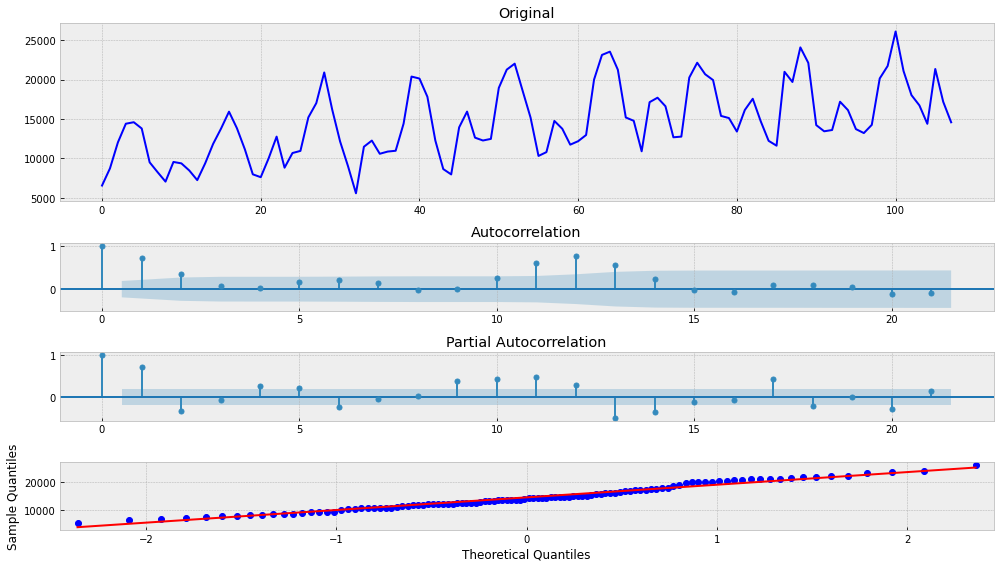

In [4]:
tsplot(car_sales)

Построим матрицу траекторий. Длину окна будем брать 40 (весь ряд 95, взяла наугад чуть меньше половины. В конце посмотрим результаты с разными размерами окна)

In [8]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [20]:
L = 40 # The window length.
t = np.arange(0, len(car_sales))
K = len(car_sales) - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([car_sales[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

X

array([[ 6550,  8728, 12026, ..., 15189, 14767, 10895],
       [ 8728, 12026, 14395, ..., 14767, 10895, 17130],
       [12026, 14395, 14587, ..., 10895, 17130, 17697],
       ...,
       [10965, 14405, 20379, ..., 16722, 14385, 21342],
       [14405, 20379, 20128, ..., 14385, 21342, 17180],
       [20379, 20128, 17816, ..., 21342, 17180, 14577]], dtype=int64)

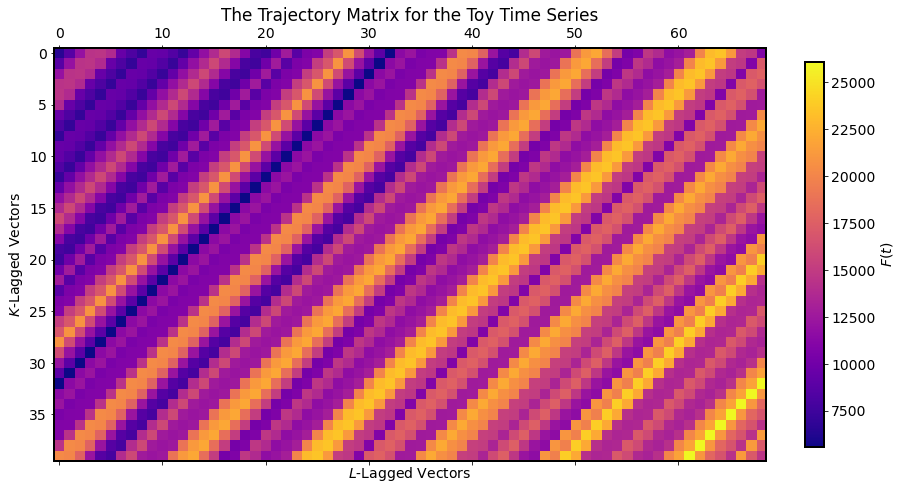

In [11]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

Разложим матрицу траекторий на 16 элементов. Посмотрим на элементарные матрицы

In [12]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T

X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

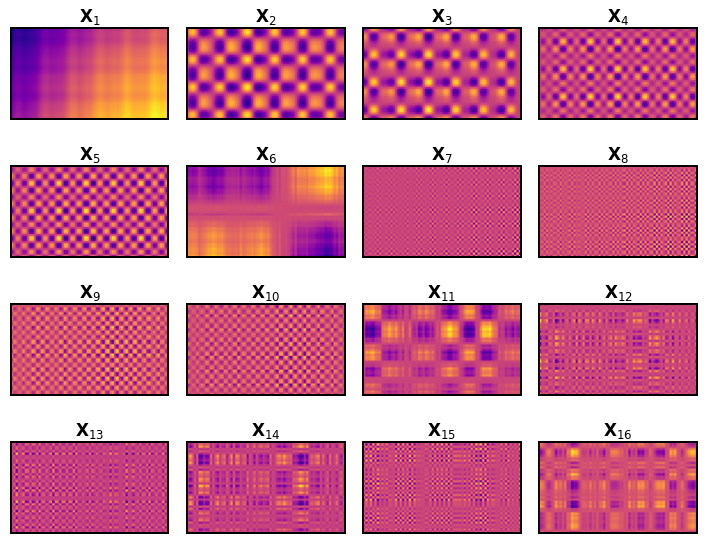

In [34]:
n = min(16, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i+1) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Первая компонента явно тренд. Следующие четыре похожи на сезонность. Причём 2/3 и 4/5 имеют похожую переодичность. 

Дальше начинаются менее очевидные матрицы:  6 - есть элементы тренда, остальные с элементами сезонности.

Построим графики относительных и кумулятивных вкладов для 16 компонент:

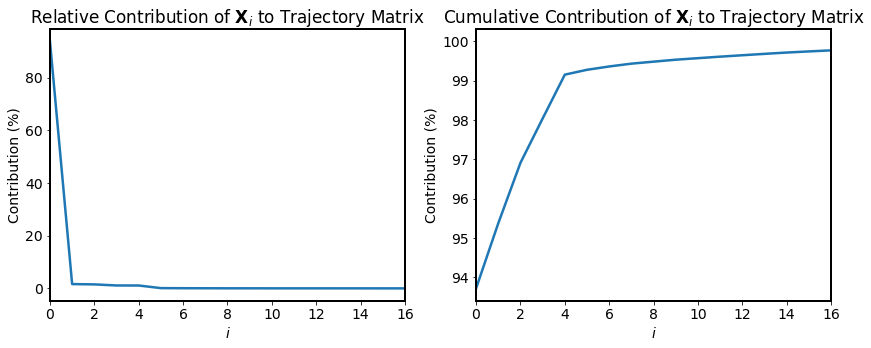

In [35]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,16)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,16)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

По графикам видно, что основной вклад вносит первая компонента тренда. Ещё 4 компоненты сезонности вносят вклад близкий к нулю (но он есть). Остальные компоненты вообще не вносят вклада.
Общий вклад первых 5-ти матриц составляет более 99%.

Теперь попробуем сгрупировать компоненты 2/3 и 3/4, и построим график, на котором будут:
- оригинальный ряд
- компонента тренда
- объединенные компоненты сезонности (два)
- шум

In [36]:
def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

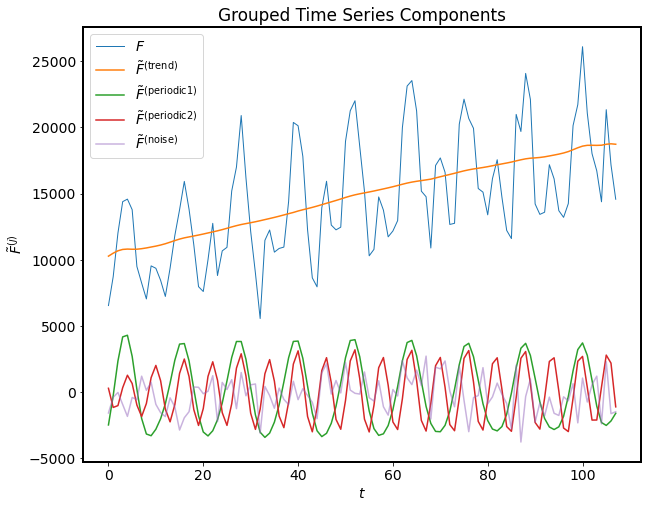

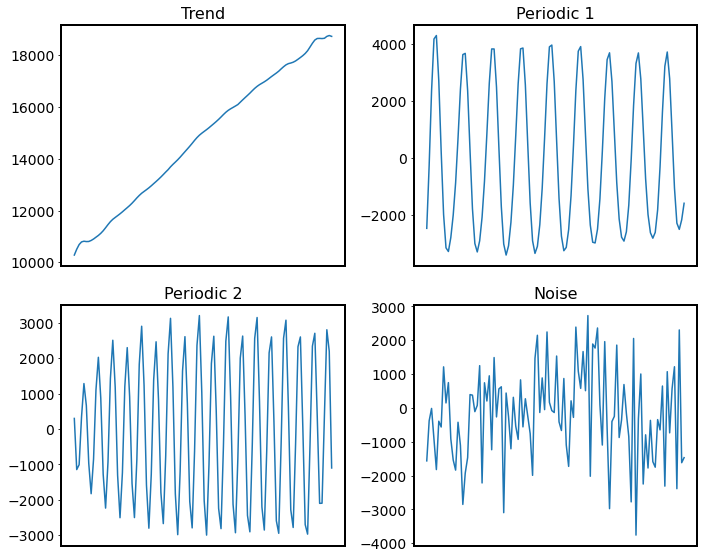

In [40]:
F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F_noise = X_to_TS(X_elem[5:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t, car_sales, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

components = [("Trend", F_trend), 
              ("Periodic 1", F_periodic1),
              ("Periodic 2", F_periodic2),
              ("Noise", F_noise)]


fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

Проверим, правильно ли мы выбрали количество компонент (пять). Для этого построим корреляционную матрицу

In [41]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

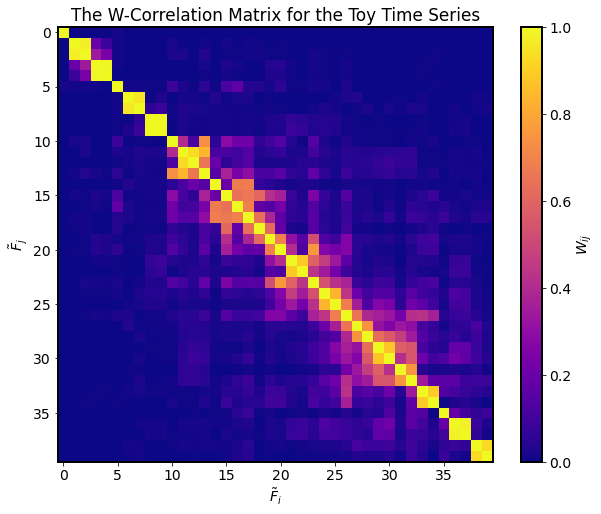

In [42]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series");

Полосы от 0 до 4 (первые 5 элементов) не польностью затемнены, но близко к этому. Приблизим матрицу

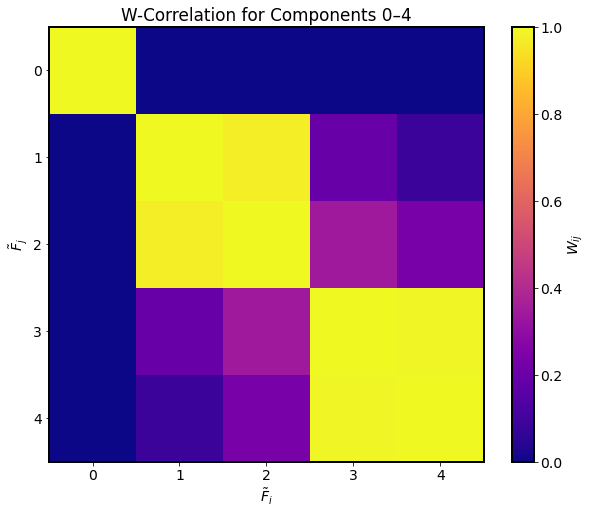

In [32]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,4.5)
plt.ylim(4.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–4");

Матрица подтверждает предыдущие выводы: первая компонента (тренда) не коррелирует с другими компонетнами, а компоненты 2/3 и 3/4 очень коррелируют между собой.

Теперь попробуем посмотреть на результаты SSA для разного размера окон. Для примера возьмём 2, 5, 25, 40

In [43]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

### L = 2

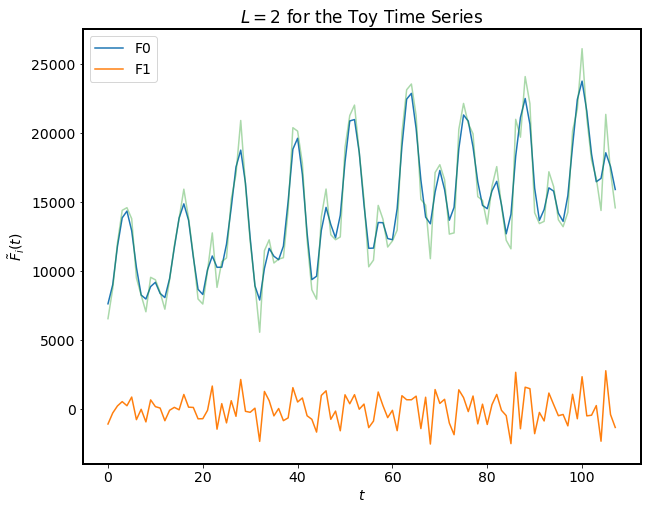

In [46]:
F_ssa_L2 = SSA(car_sales, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

Здесь отделились какие-то пиковые значения

### L = 5

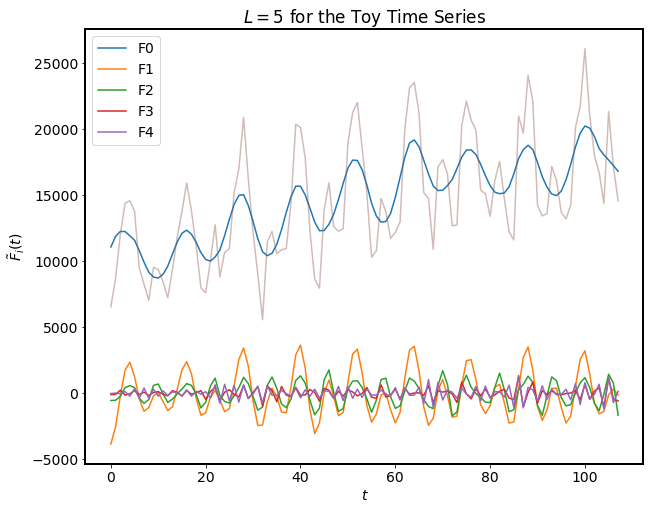

In [48]:
F_ssa_L2 = SSA(car_sales, 5)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Toy Time Series");

Здесь видно, что:
- F0 - это сглаженная версия оригинального ряда
- F1 - ярко выраженная перидичность
- F2 - тоже переодичность, но с меньшим размахом
- F3 и F4 - шум

### L = 25

Здесь уже довольно много компонент, поэтому надо сделать группировку. Строим корреляционную матрицу

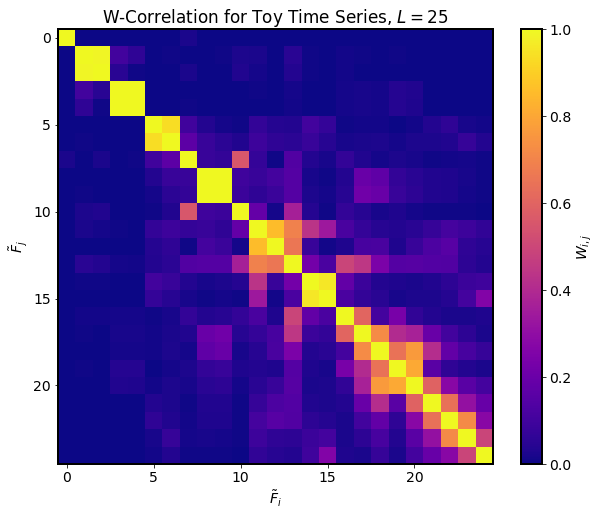

In [54]:
F_ssa_L25 = SSA(car_sales, 25)
F_ssa_L25.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=25$");

Можно распределить примерно на 3 блока: 
- F0
- F1 - F4
- F5 и дальше

Не идеально, так как F0 имеет минимальные корреляции с F6-7, а F1-F4 c F9 и другими. Попробуем применить

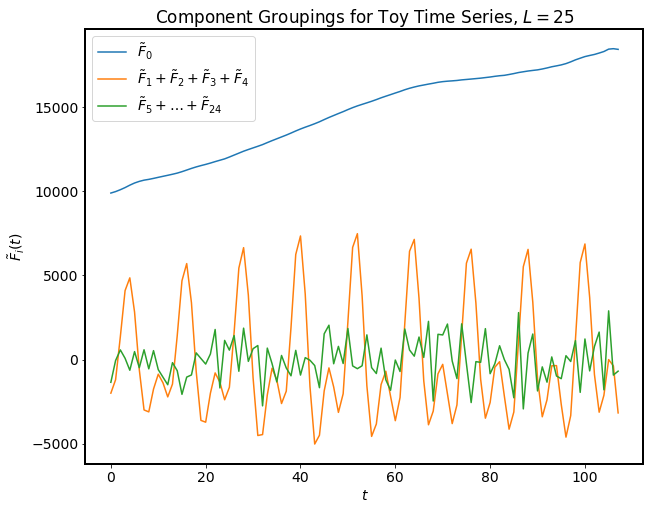

In [57]:
F_ssa_L25.reconstruct(0).plot()
F_ssa_L25.reconstruct([1,2,3,4]).plot()
F_ssa_L25.reconstruct(slice(5,25)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=25$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{24}$"
           ]);

### L = 40

Выглядит неплохо, но есть ощущение, что в шуме осталась какая-то переоджичность. Увеличим длину окна до 40, как делали в начале задания

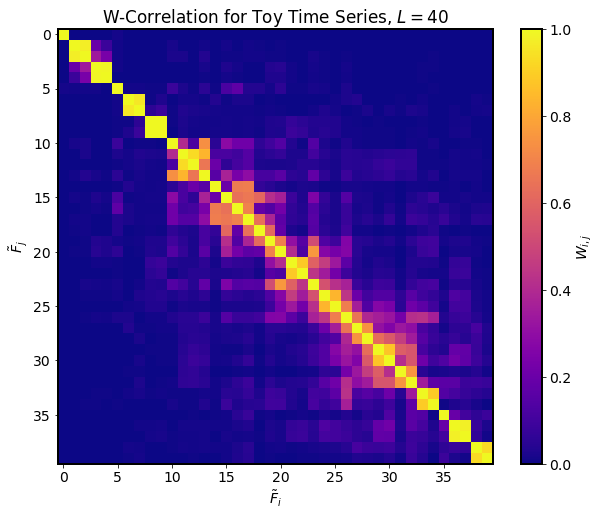

In [56]:
F_ssa_L40 = SSA(car_sales, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$");

Хм. Попробуем разбить квадрат F1-F4 на 2: F1-2 и F3-4, а также выделим отдельно квадрат F5-F9:

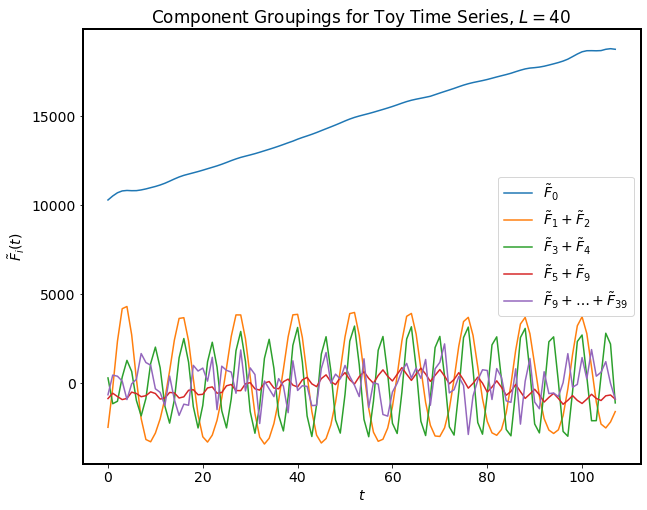

In [59]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2]).plot()
F_ssa_L40.reconstruct([3,4]).plot()
F_ssa_L40.reconstruct([5,9]).plot()
F_ssa_L40.reconstruct(slice(9,40)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=40$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+\tilde{F}_4$", 
            r"$\tilde{F}_5+\tilde{F}_9$", 
            r"$\tilde{F}_9+ \ldots + \tilde{F}_{39}$"
           ]);

Выглядит лучше, по крайней мере вторая сезонность явно уточняет оригинальный ряд, а шум стал более однородным.